In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm


import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetB4, EfficientNetB0, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import Sequential
from keras.layers import *
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input



2026-02-16 11:48:56.866573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 11:48:57.053926: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-16 11:48:57.592103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gohil/anaconda3/envs/gpu/lib/python3.9/site-packages/cv2/../../lib64:/home/gohil/anaconda3/envs/gpu/lib
2026-02-16 11:48:57.592194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [ ]:
conv_base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))

2026-02-16 11:49:05.211841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2006] Ignoring visible gpu device (device: 1, name: Quadro P400, pci bus id: 0000:18:00.0, compute capability: 6.1) with core count: 2. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2026-02-16 11:49:05.212459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 11:49:05.326644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15497 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:af:00.0, compute capability: 6.0


In [4]:
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True
block1b_activation True
block1b_se_squeeze True
block1b_se_reshape True
block1b_se_reduce True
block1b_se_expand True
block1b_se_excite True
block1b_project_conv True
block1b_project_bn True
block1b_drop True
block1b_add True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
b

In [ ]:
conv_base.trainable = False

In [6]:
conv_base.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 380, 380, 3)  0           ['normalization[0][0

In [7]:
batch_size = 128
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"

)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/home/gohil/Downloads/AI/clg_projects/01_01_Plant_Diseases_Detection_Binary/Maize_Leaf_380/train',
    target_size=(380,380),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    '/home/gohil/Downloads/AI/clg_projects/01_01_Plant_Diseases_Detection_Binary/Maize_Leaf_380/test',
    target_size=(380,380),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7079 images belonging to 5 classes.
Found 1773 images belonging to 5 classes.


In [ ]:
model = Sequential()

model.add(conv_base)
model.add(GlobalAveragePooling2D())

model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(5, activation="softmax"))


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               229376    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
callback = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True 
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

best_model_checkpoint = ModelCheckpoint(
    filepath='/home/gohil/Downloads/AI/clg_projects/01_01_Plant_Diseases_Detection_Binary/result models/Maize_Leaf_380_train_efficientnet_b4.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=True,
)

periodic_model_checkpoint = ModelCheckpoint(
    filepath='/home/gohil/Downloads/AI/clg_projects/01_01_Plant_Diseases_Detection_Binary/result models/Maize_Leaf_380_train_efficientnet_b4{epoch:02d}_efficientnet_b4.h5',
    save_freq='epoch',
    period=5,
    verbose=1,
    save_weights_only=True 
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callback, best_model_checkpoint, periodic_model_checkpoint]
)

Epoch 1/50


2026-02-16 11:50:14.513645: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


56/56 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.8476
Epoch 1: val_accuracy improved from -inf to 0.94191, saving model to /home/gohil/Downloads/AI/clg_projects/01_01_Plant_Diseases_Detection_Binary/result models/Maize_Leaf_380_train_efficientnet_b4.h5
56/56 [==============================] - 239s 4s/step - loss: 0.4385 - accuracy: 0.8476 - val_loss: 0.2231 - val_accuracy: 0.9419
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9484
Epoch 2: val_accuracy improved from 0.94191 to 0.95319, saving model to /home/gohil/Downloads/AI/clg_projects/01_01_Plant_Diseases_Detection_Binary/result models/Maize_Leaf_380_train_efficientnet_b4.h5
56/56 [==============================] - 226s 4s/step - loss: 0.1566 - accuracy: 0.9484 - val_loss: 0.1399 - val_accuracy: 0.9532
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9606
Epoch 3: val_accuracy improved from 0.95319 to 0.96616, saving model

After running the above cell to set the environment variables, you can then execute your existing training or processing code. TensorFlow will attempt to utilize the specified number of threads for CPU-bound operations.

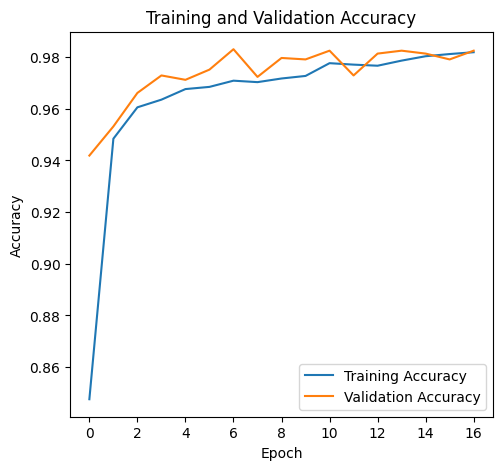

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

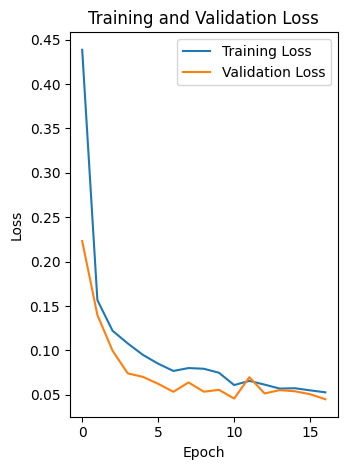

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)


14/14 [==============================] - 28s 2s/step


In [ ]:
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


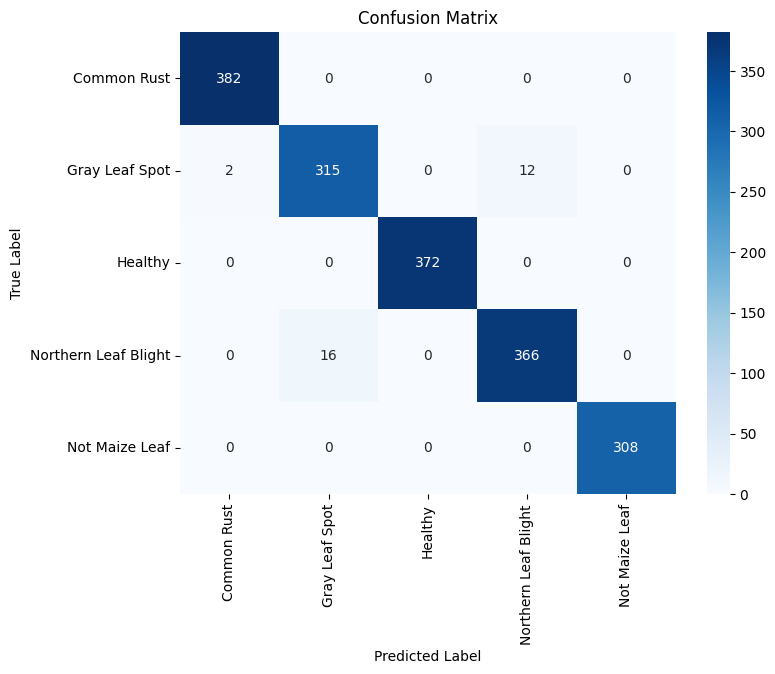

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


Classification Report:
                      precision    recall  f1-score   support

         Common Rust       0.99      1.00      1.00       382
      Gray Leaf Spot       0.95      0.96      0.95       329
             Healthy       1.00      1.00      1.00       372
Northern Leaf Blight       0.97      0.96      0.96       382
      Not Maize Leaf       1.00      1.00      1.00       308

            accuracy                           0.98      1773
           macro avg       0.98      0.98      0.98      1773
        weighted avg       0.98      0.98      0.98      1773

